In [4]:
#!pip install lightfm
#!pip install tabulate

# Data Understanding

In [2]:
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
import numpy as np
from scipy.sparse import csr_matrix
from lightfm import evaluation
from tabulate import tabulate
from sklearn.neighbors import NearestNeighbors

/Users/eleonorasbrissa/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
# Read csv files
df = pd.read_csv('retail.csv')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [6]:
#number of customers
df['CustomerID'].nunique()

4372

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Invoice feature needs to be changed to datetime object:

In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

From a first analysis we saw that customer ID contains null values. Let's check how many they are:

In [9]:
#null customers
df[df['CustomerID'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


We saw there are 10624 rows containing cancellations or returns of items as their quantity is less than 1. We decided to keep them inside the dataset as when the matrix user/customer is created, they will be subtracted from the quantities bought, giving a better overview of the customers preferencies.

In [10]:
df[df['Quantity']<1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


we also found 2 rows related to negative unit price. we will drop those as they don't bring any additional value to the dataset.

In [11]:
unitpriceless1=df[df['UnitPrice']<0]
unitpriceless1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [12]:
unitpriceless1index=unitpriceless1.index.tolist()
df.drop(unitpriceless1index, axis=0, inplace=True)
df.reset_index(inplace=True)

We will now have a look at the distribution of events, from a customer point of view to an item point of view.

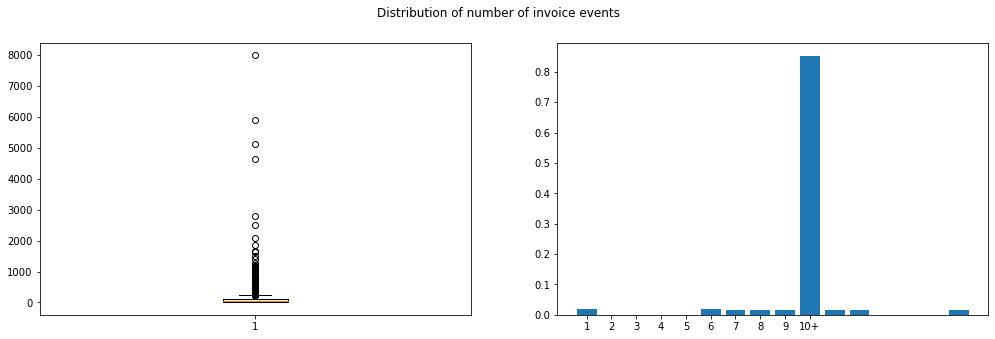

98.19% of customers have more than 1 event!


In [13]:
# Distribution of number of customers events
data1 = df['CustomerID'].value_counts()  # count of events per customerID
data2 = data1.value_counts(normalize=True)[:9]
data2[10] = data1.value_counts(normalize=True)[9:].sum()  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
ax2.bar(data2.index, data2.values)

ax2.set_xticks(list(range(1,11)))
ax2.set_xticklabels(list(range(1,10)) +['10+'])
fig.suptitle("Distribution of number of invoice events")

plt.show()
print("{0:.2f}% of customers have more than 1 event!".format(100 * (np.sum(data1 > 1) / data1.shape[0])))

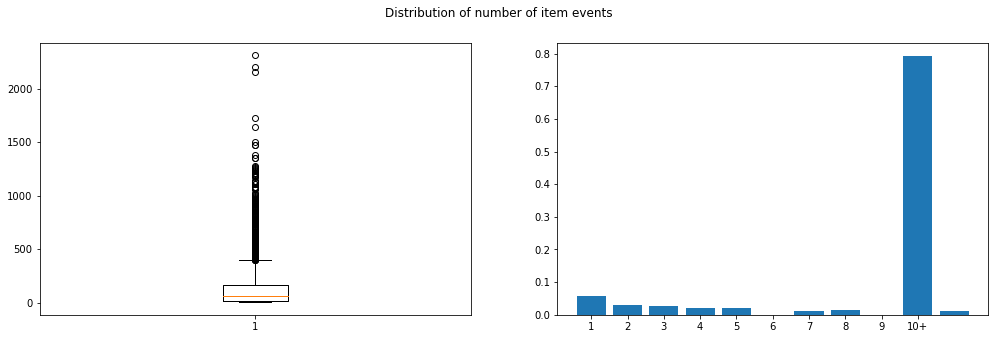

94.25% of items have more than 1 event!


In [14]:
# Distribution of number of item events
data1 = df['StockCode'].value_counts()  # count of events per item
data2 = data1.value_counts(normalize=True)[:9]
data2[10] = data1.value_counts(normalize=True)[9:].sum()  # count of counts of events per visitorid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
ax1.boxplot(data1)
ax2.bar(data2.index, data2.values)

ax2.set_xticks(list(range(1,11)))
ax2.set_xticklabels(list(range(1,10)) +['10+'])
fig.suptitle("Distribution of number of item events")

plt.show()
print("{0:.2f}% of items have more than 1 event!".format(100 * (np.sum(data1 > 1) / data1.shape[0])))

Let's also have a look at the distribution of sales:

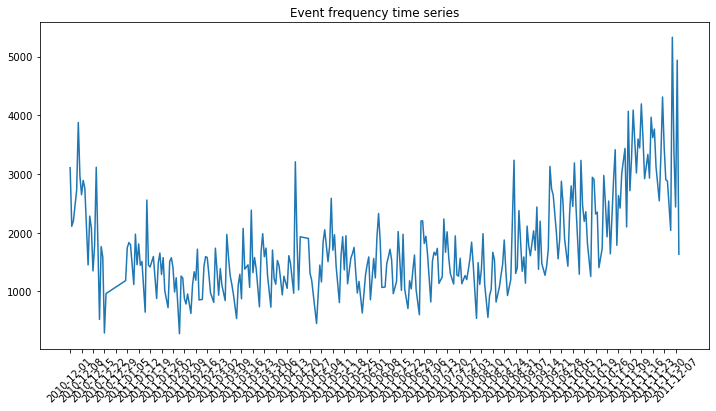

In [15]:
# Visualize number of events per day
data = pd.DatetimeIndex(df['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.title('Event frequency time series')
plt.show()

In [16]:
# How many weeks does the dataset has?
diff = (data.index.max() - data.index.min())
print(f"The dataset has {diff.days} days, corresponding to {diff.days//7} weeks.")

The dataset has 373 days, corresponding to 53 weeks.


# Data Preparation

### CustomerID with null values

We decided to drop the customers that don't have a customerID, as they account for 1 purchase that won't be remembered by the system as next time they will be considered as new customers again.

In [17]:
dfnewcst=df[df['CustomerID'].isna()]
dfnewcst.head(5)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [18]:
dfnewcst.shape

(135078, 9)

In [19]:
#saving the nan customers in a list and dropping them from df
newcstindex=dfnewcst.index.tolist()
df.drop(newcstindex, axis=0, inplace=True)
df.reset_index(inplace=True)
dfnewcst.reset_index(inplace=True)

In [20]:
df.shape

(406829, 10)

## Reduce sparsity by increasing the number of 1s

In [21]:
#point of view of the customer
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of customers: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('% of ones: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of customers: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('% of ones: {:4.3f}%'.format(sparsity))
    return df

In [22]:
# get limited dataset
df_limited = threshold_ratings(df, 7, 7)

Raw dataset info 
-----------------
Number of customers: 4372
Number of items: 3684
% of ones: 2.526%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of customers: 3984
Number of items: 3064
% of ones: 3.307%


We decided to consider just the customers that did more than 7 purchases in order to increase the number of ones in the sparse matrix.

## Train Test Split

In [23]:
df=df_limited

In [24]:
# Train-test split
start_train = df['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(48, unit='w')
end_test = start_test + pd.to_timedelta(5, unit='w')

# Create new limited df
df_limited = df.loc[(df['InvoiceDate'] > start_train) & (df['InvoiceDate'] <= end_test)]

# Create train_split flag
df['train_split'] = (df['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df['train_split'].mean()))

Proportion of train events: 0.80


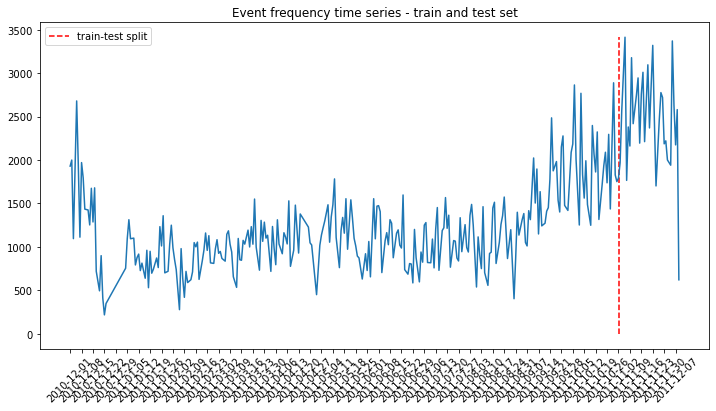

In [25]:
# Visualize train and test set
data = pd.DatetimeIndex(df['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

We did the train test split based on time. 
Train data account for 80% while test is related to 20%

We will now create the Customer/item matrix

In [26]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat = df['CustomerID'].astype('category')
item_cat = df['StockCode'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (3064, 3984) and test set shape: (3064, 3984)
train set percentage of zeros: 98.1917552717397 and test set percentage of zeros: 99.45537699099269


In [27]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [28]:
# most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df.loc[(df['CustomerID'] == user_id) & (df['StockCode'] == item_id) & (df['train_split'] == 1)]

,level_0,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,train_split
1422,1423,1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911.0,EIRE,1
8614,12119,12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911.0,EIRE,1
8947,12452,12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911.0,EIRE,1
24735,37644,37644,539473,C2,CARRIAGE,1,2010-12-19 14:24:00,50.0,14911.0,EIRE,1
26731,42332,42332,539984,C2,CARRIAGE,1,2010-12-23 14:58:00,50.0,14911.0,EIRE,1
...,...,...,...,...,...,...,...,...,...,...,...
298362,401114,401116,571425,C2,CARRIAGE,1,2011-10-17 12:41:00,50.0,14911.0,EIRE,1
305324,409729,409731,572069,C2,CARRIAGE,1,2011-10-20 13:24:00,50.0,14911.0,EIRE,1
309958,414462,414464,572459,C2,CARRIAGE,1,2011-10-24 12:53:00,50.0,14911.0,EIRE,1
321049,427574,427576,573391,C2,CARRIAGE,1,2011-10-30 14:57:00,50.0,14911.0,EIRE,1


# Modeling

## ALS Model

We tried to apply the ALS Model to our dataset, as well as construct a function to recommend the most popular items to new customers, but the results were poor. 

In [29]:
# initialize a model
alpha = 40  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=20, regularization=80, iterations=30, random_state=0)
# train the model on a sparse matrix of item/user/confidence weights
als_model.fit((item_user_train * alpha).astype('double'))

### Evaluation


In [30]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [31]:
# initialize a model
alpha = 30  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=30, regularization=100, iterations=40, random_state=0)
als_model.fit((item_user_train * alpha).astype('double'))

In [32]:
# Fitting PopularRecommender model - cold start problem
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [33]:
# Evaluate model with sparsity reduction 10,10
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.087973,0.054791
map,0.038768,0.022969
ndcg,0.090257,0.054434
auc,0.515271,0.508045


## LIGHTFM

We then decided to apply the lightfm algorithm in order to solve the issue.  

Here below all the functions we used for the LightFM algorithm:  
Dictionary of items and users and
Recommendation function based on the model.

In [34]:
def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict


def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:][interactions.loc[user_id,:] >= 1].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(i)
            

        print("\n Recommended Items:")
        for i in scores:
            print(i)
            
    return return_score_list

def top_k(rec_list):
    items = pd.DataFrame.from_dict(item_dict, orient='index', columns = ['description']).reset_index()
    items.columns = ['StockCode','Description']
    print(items.iloc[rec_list])

In [35]:
df.drop('level_0', axis=1, inplace = True)
df.reset_index(inplace = True)

#from sparse matrix to df pandas for the following function
df_train = pd.DataFrame.sparse.from_spmatrix(user_item_train)

#create dictionaries of user ids and item descriptions
user_dict = create_user_dict(pd.DataFrame.sparse.from_spmatrix(user_item_train))
item_dict = create_item_dict(df, 'StockCode', 'Description')

In [36]:
#create and fit lightfm model
model = LightFM(learning_rate=0.05, loss='warp')
fit = model.fit(user_item_train, epochs = 30, num_threads = 4)

### Recommendation function and example

As an example, we will call 5 items recommendation for user id 13408.
The first result is a list of what the user has already bought.
The second cell is related to the items the model is recommending.

In [37]:
rec_list = sample_recommendation_user(model = fit, 
                                      interactions = df_train, 
                                      user_id = user_map.get(13408), #insert the user_id inside the user_map.get(*)
                                      user_dict = user_dict,
                                      item_dict = item_dict, 
                                      nrec_items = 5,
                                      show = True)

Known Likes:
3062
3060
2975
2973
2915
2887
2875
2874
2858
2802
2795
2793
2790
2787
2740
2690
2592
2561
2541
2540
2439
2433
2430
2402
2401
2363
2332
2264
2262
2220
2171
2166
2133
2132
2115
2114
2108
2091
2090
2083
2074
2071
2064
2058
2054
2049
2023
2018
2012
2010
2005
2004
2003
2001
1994
1993
1992
1991
1985
1968
1967
1963
1958
1952
1943
1935
1925
1924
1923
1922
1921
1919
1918
1917
1908
1907
1894
1892
1891
1890
1889
1888
1876
1873
1861
1849
1848
1846
1827
1823
1822
1821
1820
1807
1805
1762
1759
1742
1741
1740
1709
1700
1691
1689
1688
1670
1642
1641
1640
1639
1627
1600
1599
1598
1589
1539
1532
1523
1515
1513
1510
1493
1492
1491
1490
1485
1484
1474
1472
1471
1466
1445
1443
1419
1413
1412
1411
1400
1382
1381
1347
1325
1309
1255
1228
1227
1225
1217
1216
1192
1184
1182
1180
1174
1172
1135
1131
1126
1121
1106
1105
1078
1071
1070
1067
1043
982
980
946
945
944
943
918
915
893
890
887
886
885
883
882
880
853
822
821
816
799
798
794
792
790
786
784
782
781
688
643
623
587
586
545
536
535
530
529
5

2106
2766
712
1542
2954
598
2779
2303
431
1209
289
30
319
113
1661
2422
2489
2933
2289
1298
2860
2423
2775
2819
81
497
10
720
413
2145
2147
2457
457
82
1092
95
2958
2867
1285
2315
2159
506
479
992
2274
1027
312
2453
2667
1215
1057
139
2424
2822
1367
726
2353
31
583
650
148
2839
2752
2396
2549
1119
2479
2843
2783
2571
151
2865
367
1390
2927
1427
1617
445
399
62
419
1310
567
446
609
2391
401
1835
2663
3
2362
676
1117
2614
608
2714
2222
2307
2856
267
24
522
2292
1176
648
2788
2835
1199
89
2515
253
158
2408
2469
649
1616
105
1295
2840
2526
2610
664
13
2744
1506
803
640
266
41
1042
45
2698
861
562
393
666
165
2364
2112
2354
568
1091
251
504
2371
1744
625
581
391
2337
1501
673
2501
1094
343
2844
2767
993
2621
214
2567
1169
305
157
153
2582
578
237
2344
1037
717
177
456
205
1860
2782
2599
2920
2468
2434
1602
1743
2707
26
2320
12
2748
973
1271
2177
1611
2638
2726
498
2656
178
2776
2444
2502
1210
463
34
14
2966
2870
2791
44
20
2812
2659
628
871
2897
680
2284
2760
405
869
47
2626
2399
2268
2757


Here the five top items for that user.

In [38]:
top_k(rec_list)

     StockCode                         Description
1692    84569A          PACK 3 IRON ON DOG PATCHES
1927     22055  MINI CAKE STAND  HANGING STRAWBERY
2392    84859C                  PINK DISCO HANDBAG
358      21242                RED RETROSPOT PLATE 
889      21629    SQUARE FLOOR CUSHION VINTAGE RED


### Evaluation LightFM

For the evaluation of the model, we will use  recall at k, precision at k and auc 

In [39]:
recall = evaluation.recall_at_k(model, user_item_test, train_interactions = user_item_train, k=10, user_features=None, item_features=None, preserve_rows=False, num_threads=1, check_intersections=False)
precision= evaluation.precision_at_k(model, user_item_test, train_interactions=None, k=10, user_features=None, item_features=None, preserve_rows=False, num_threads=1, check_intersections=True)
auc = evaluation.auc_score(model, user_item_test, train_interactions=None, user_features=None, item_features=None, preserve_rows=False, num_threads=1, check_intersections=True)

In [40]:
eval_res = [['recall', 'precision', 'auc'], [recall.mean().round(3), precision.mean().round(3), auc.mean().round(3)]]
print(tabulate(eval_res, headers='firstrow'))

  recall    precision    auc
--------  -----------  -----
   0.101        0.147  0.803


# Cold start problem

## Most popular items

For the cold start problem the first step is to provide the user with the most popular items of the last month.
Choose the month you want to look at and fill the popular_item function with the number of the month.

In [44]:
def popular_items(month_no, country):
    df_month = df[df['InvoiceDate'].dt.month == month_no]
    df_country = df_month[df_month['Country']==country]
    print("Most popular items during", month_no,"/2011", "in", country, "\n" , "\n" , df_country.groupby(by=['StockCode','Description']).sum()['Quantity'].sort_values(ascending=False)[0:5])

As an example we will consider the most popular items during November:

In [46]:
popular_items(11,'Netherlands')

Most popular items during 11 /2011 in Netherlands 
 
 StockCode  Description                     
22492      MINI PAINT SET VINTAGE              1152
22152      PLACE SETTING WHITE STAR             432
22356      CHARLOTTE BAG PINK POLKADOT          400
21810      CHRISTMAS HANGING STAR WITH BELL     384
20973      12 PENCIL SMALL TUBE WOODLAND        384
Name: Quantity, dtype: int64


## KNN

For the second part of the cold start problem, when a new user enters a page of a product, we want to display the closest items based on distance calculated in the item-user matrix.
Write the item code of the product you are on the page now, and fill it in the get_suggestion_new function

In [47]:
nbrs = NearestNeighbors(n_neighbors = 5, algorithm='brute', metric='cosine').fit(user_item_train.T)
#we used cosine to measure the distance

In [48]:
distances, indices = nbrs.kneighbors(user_item_train.T)

In [49]:
def get_suggestion_new(item_now):
    
    item_row = item_map.get(item_now) #get row of the item in the matrix
    array_neigh = indices[item_row] #look for the closest items from knn
    list_items=[]
    for i in array_neigh: #list the item codes of the array
        list_items.append(list(item_map.keys())[list(item_map.values()).index(i)])
    list_items.remove(item_now)
    df_filtered = df[df['StockCode'].isin(list_items)]
    return(df_filtered['Description'].unique().tolist())

For example, if a new customer enters item 22752 related to SET 7 BABUSHKA NESTING BOXES:

In [50]:
print("You may also like:")
get_suggestion_new('22752')

You may also like:


['GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER RED POLKA DOT',
 'VINTAGE BILLBOARD LOVE/HATE MUG',
 'HAND WARMER RED RETROSPOT',
 'IVORY EMBROIDERED QUILT ']